In [ ]:
!pip install earthengine-api

In [ ]:
!pip install geemap

In [ ]:
!pip install scikit-image


In [ ]:
!pip install geopandas rasterio


In [ ]:
!pip install fastkml


In [8]:
# prompt: how to authenticate to a gee project
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()


# Import packages

In [9]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
import ee
import geopandas as gpd
import geemap
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
import xgboost as xgb
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [ ]:
ee.Authenticate()


# 1. Exploratory Data Analysis

# 1.1 Visualizing ESA WorldCover Data for the Kabylie Region

In [ ]:
# Create a map for visualization
Map = geemap.Map()
# Define the Kabylie region as the area of interest (AOI)
kabylie = ee.Geometry.Rectangle([3.5, 36.4, 5.5, 37.2])

# Load ESA WorldCover dataset
worldCover = ee.ImageCollection('ESA/WorldCover/v100').first()

# Visualization parameters for WorldCover
vis_params = {
    'bands': ['Map'],
    'min': 10,
    'max': 100,
    'palette': ['006400', 'ffbb22', 'ffff4c', 'f096ff', 'fa0000', 'b4b4b4', 'f0f0f0', '0064c8', '0096a0', '00cf75']
}

# Add the WorldCover data to the map
Map.addLayer(worldCover.clip(kabylie), vis_params, 'WorldCover')

# Display the map
Map.centerObject(kabylie, 9)
Map.addLayerControl()
Map


Map(center=[36.80348934319949, 4.499999999999918], controls=(WidgetControl(options=['position', 'transparent_b…

## 1.2 Exporting and Visualizing Sentinel-2 Satellite Data for the AOI

In [ ]:
# Define the area of interest (AOI)
aoi = ee.Geometry.Rectangle([3.5, 36.4, 5.5, 37.2])

# Load Sentinel-2 Harmonized Collection and filter by date and bounds
sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate('2020-01-01', '2020-12-31').filterBounds(aoi)
satellite_image = sentinel.median()

# Export the satellite image to Google Drive
task = ee.batch.Export.image.toDrive(
    image=satellite_image.clip(aoi),
    description='Sentinel2_Export',
    scale=10,
    region=aoi,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

# Start the export task
task.start()


# Visualize the data using geemap
m = geemap.Map()
m.centerObject(aoi, zoom=10)
m.addLayer(satellite_image.clip(aoi), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 Image')
m


Map(center=[36.80348934319949, 4.499999999999918], controls=(WidgetControl(options=['position', 'transparent_b…

## 1.3 Sampling and Exporting Validation Points for Forest Masking using Sentinel-2 and ESA WorldCover Data

In [ ]:
# Define the Kabylie region as the area of interest (AOI)
aoi = ee.Geometry.Rectangle([3.5, 36.4, 5.5, 37.2])

# Load ESA WorldCover dataset as an image (first image in the collection)
worldCover = ee.ImageCollection('ESA/WorldCover/v100').first().select('Map').clip(aoi)

# Load Sentinel-2 Harmonized Collection, filter by date and region
sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate('2020-01-01', '2020-12-31').filterBounds(aoi).median()

# Define the number of validation points
num_validation_points = 2000

# Sample validation points from both Sentinel-2 and WorldCover data
validation_points = sentinel.addBands(worldCover).sample(
    region=aoi,
    scale=10,
    numPixels=num_validation_points,
    seed=1,
    tileScale=4
)

# Export the validation points to Google Drive as a shapefile
task = ee.batch.Export.table.toDrive(**{
    'collection': validation_points,
    'description': 'ValidationDataset_Export',
    'fileFormat': 'SHP',
    'folder': 'EarthEngineExports'
})

task.start()
print('Validation points export task started.')

# Apply a mask to only show forest areas (WorldCover class 10 is forest)
forestMask = worldCover.eq(10)  # WorldCover class 10 represents forests
forestOnly = worldCover.updateMask(forestMask)

# Add the forest layer to the map
m = geemap.Map()
m.centerObject(aoi, zoom=10)
m.addLayer(forestOnly.clip(aoi), {'min': 10, 'max': 100, 'palette': ['006400']}, 'WorldCover Forests')
m.addLayer(sentinel.clip(aoi), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 Image')
m


Validation points export task started.


Map(center=[36.80348934319949, 4.499999999999918], controls=(WidgetControl(options=['position', 'transparent_b…

### Loading and Inspecting Validation Polygons from Shapefile

In [ ]:
# Load the validation shapefile (digitized polygons)
validation_data = gpd.read_file('/content/drive/MyDrive/ValidationData_Export/ValidationData_Export.shp')

# Print validation data to inspect
print(validation_data.head())


                                            geometry
0  MULTIPOLYGON (((3.8409 36.71549, 3.88313 36.72...


## 1.4 Summary Statistics of Validation Data

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  1 non-null      geometry
dtypes: geometry(1)
memory usage: 136.0 bytes
None
                                                 geometry
count                                                   1
unique                                                  1
top     MULTIPOLYGON (((3.840901947476709 36.715486512...
freq                                                    1
Coordinate Reference System (CRS): EPSG:4326


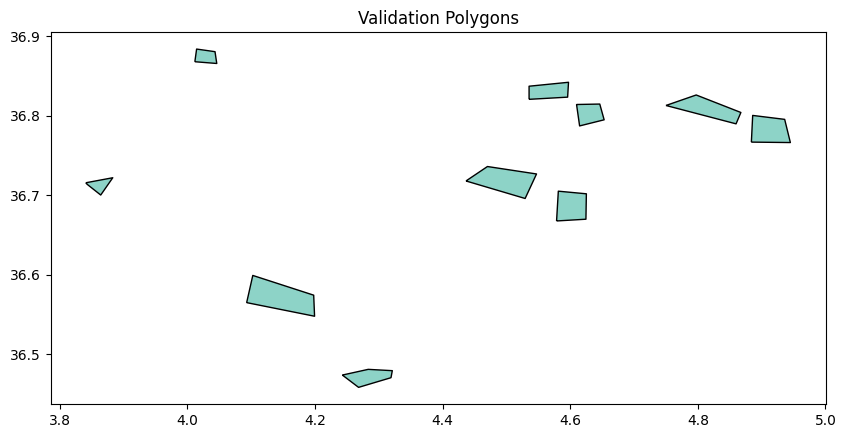

In [ ]:
# Load the validation shapefile
validation_data = gpd.read_file('/content/drive/MyDrive/ValidationData_Export/ValidationData_Export.shp')

# Display summary statistics and information
print(validation_data.info())  
print(validation_data.describe())  

# Check the coordinate reference system (CRS)
print("Coordinate Reference System (CRS):", validation_data.crs)

# Plot the validation polygons
validation_data.plot(figsize=(10, 8), edgecolor='black', cmap='Set3')
plt.title("Validation Polygons")
plt.show()


## 1.5 Check for missing or null geometries

In [ ]:
# Check for missing or null geometries in the validation dataset
missing_geometries = validation_data['geometry'].isnull().sum()

# Display the count of missing geometries
print(f"Number of missing geometries: {missing_geometries}")


Number of missing geometries: 0


# 2. Feature Extraction

## 2.1 NDVI Calculation and Visualization

In [115]:
# Define the area of interest (AOI)
aoi = ee.Geometry.Rectangle([3.5, 36.4, 5.5, 37.2])

# Load Sentinel-2 Harmonized Collection and filter by date and region
sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate('2020-01-01', '2020-12-31') \
    .filterBounds(aoi) \
    .median()

# Calculate NDVI (Normalized Difference Vegetation Index)
ndvi = sentinel.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Export the NDVI layer to Google Drive
task = ee.batch.Export.image.toDrive(**{
    'image': ndvi.clip(aoi),
    'description': 'Sentinel2_NDVI_Export',
    'scale': 10,
    'region': aoi,
    'maxPixels': 1e13,
    'fileFormat': 'GeoTIFF'
})

# Start the export task
task.start()

# Visualization for NDVI
ndvi_vis = {
    'min': 0,
    'max': 1,
    'palette': ['blue', 'white', 'green']  
}

# Create the map for visualization
m = geemap.Map(center=[36.7, 4.0], zoom=10)

# Add NDVI layer to the map
m.addLayer(ndvi.clip(aoi), ndvi_vis, 'NDVI')

# Add a layer control to switch layers on/off
m.addLayerControl()

# Display the map by calling the map object directly
m


Map(center=[36.7, 4.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

# 3. Model Training

### 3.1 Loading and Aligning WorldCover Forest Mask and NDVI Data for Analysis

In [12]:
# Load WorldCover forest data (binary mask, forest=1, non-forest=0)
forest_path = '/content/drive/MyDrive/ValidationData_Export/ValidationData_Export_rasterized.tif'
ndvi_path = '/content/drive/MyDrive/EarthEngineExports/Sentinel2_Export-0000004608-0000004608.tif'

with rasterio.open(forest_path) as forest_raster:
    forest_data = forest_raster.read(1)  # Load band data (forest mask)
    forest_transform = forest_raster.transform

with rasterio.open(ndvi_path) as ndvi_raster:
    ndvi_data = ndvi_raster.read(1)  # Load NDVI band data
    ndvi_transform = ndvi_raster.transform

# Check if the two rasters align and match CRS
assert forest_raster.crs == ndvi_raster.crs, "CRS mismatch between NDVI and WorldCover data"


### 3.2 Resampling NDVI Data to Match Forest Mask Resolution

In [13]:
from rasterio.warp import reproject, Resampling

# Resample NDVI to match the forest data resolution (if needed)
if forest_raster.shape != ndvi_raster.shape:
    ndvi_resampled = np.zeros(forest_raster.shape, dtype=ndvi_data.dtype)
    reproject(
        source=ndvi_data,
        destination=ndvi_resampled,
        src_transform=ndvi_transform,
        dst_transform=forest_transform,
        src_crs=ndvi_raster.crs,
        dst_crs=forest_raster.crs,
        resampling=Resampling.nearest
    )
    ndvi_data = ndvi_resampled


### 3.3 Preparing and Flattening Feature Arrays for Forest Classification

In [14]:
# Stack the features (e.g., NDVI and potentially other bands)
features = np.stack([ndvi_data], axis=-1)  # Add other bands like NIR, Red if available

# Flatten the arrays for classification
X = features.reshape(-1, features.shape[-1])  # Features (e.g., NDVI)
y = forest_data.reshape(-1)  # Labels (forest = 1, non-forest = 0)

# Remove missing or invalid data (e.g., -9999 for no data)
valid_mask = (y >= 0) & (X[:, 0] != -9999) 
X = X[valid_mask]
y = y[valid_mask]


In [15]:
X

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [16]:
y

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

### 3.4 Imputation, Train-Test Split, and Sampling for Forest Classification Dataset

In [17]:
# Create an imputer to fill NaN values with the mean
imputer = SimpleImputer(strategy='mean')

# Apply imputer to features (X)
X_imputed = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Sample 1 million records from X_train and y_train
np.random.seed(42)  # For reproducibility
if X_train.shape[0] > 1000000:  # Ensuring we have enough records
    sample_indices = np.random.choice(X_train.shape[0], size=1000000, replace=False)
    X_train_sampled = X_train[sample_indices]
    y_train_sampled = y_train[sample_indices]
if X_test.shape[0] > 1000000:  # Ensuring we have enough records
    sample_indices = np.random.choice(X_test.shape[0], size=1000000, replace=False)
    X_test_sampled = X_test[sample_indices]
    y_test_sampled = y_test[sample_indices]
else:
    X_train_sampled, y_train_sampled = X_train, y_train  # Use all if less than 1 million

# Check shapes of the sampled datasets
print(f"Sampled X_train shape: {X_train_sampled.shape}")
print(f"Sampled y_train shape: {y_train_sampled.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Sampled X_train shape: {X_test_sampled.shape}")
print(f"Sampled y_train shape: {y_test_sampled.shape}")



Sampled X_train shape: (1000000, 1)
Sampled y_train shape: (1000000,)
X_test shape: (9388416, 1)
Sampled X_train shape: (1000000, 1)
Sampled y_train shape: (1000000,)


In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(37553664, 1)
(37553664,)
(9388416, 1)
(9388416,)


### 3.5 Training and Evaluating a RandomForest Classifier for Forest Classification

In [19]:
# Train the RandomForest model
rf = RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state=42)  #  square root of features
rf.fit(X_train_sampled, y_train_sampled)

# Evaluate the model
y_pred = rf.predict(X_test_sampled)
print(f"Initial Accuracy: {accuracy_score(y_test_sampled, y_pred):.4f}")

Initial Accuracy: 0.9680


In [56]:
import joblib
# Save the model to a file
model_filename = "/content/drive/MyDrive/ValidationData_Export/random_forest_model.pkl"
joblib.dump(rf, model_filename)

print(f"Model saved to {model_filename}")

Model saved to /content/drive/MyDrive/ValidationData_Export/random_forest_model.pkl


### 3.6 Pseudo-Labeling with RandomForest Classifier for Semi-Supervised Learning

In [20]:
# Predict probabilities on the unlabeled data
y_proba = rf.predict_proba(X_test_sampled)

# Pseudo-labeling: Add confident predictions as new training data
confidence_threshold = 0.9  # Only considering predictions with >90% confidence
pseudo_labels = np.argmax(y_proba, axis=1)  # Get predicted labels
confident_predictions = np.max(y_proba, axis=1) > confidence_threshold

# Add confident pseudo-labels to the training set
X_train_pseudo = np.vstack([X_train_sampled, X_test_sampled[confident_predictions]])
y_train_pseudo = np.concatenate([y_train_sampled, pseudo_labels[confident_predictions]])

# Retrain the model with the original and pseudo-labeled data
rf.fit(X_train_pseudo, y_train_pseudo)

# Evaluate again
y_pred = rf.predict(X_test_sampled)
print(f"Accuracy After Pseudo-Labeling: {accuracy_score(y_test_sampled, y_pred):.4f}")


Accuracy After Pseudo-Labeling: 0.9680


SUMMARY


Resampling NDVI: We ensured that the NDVI data matched the forest raster data resolution before proceeding with the feature extraction.

Stacking Features: NDVI was used as a feature, and other bands could potentially be added for classification purposes.

Handling Missing Data: We used SimpleImputer to handle NaN values in the features, replacing them with the mean.

RandomForest Training: The model was trained using a random forest classifier after selecting a subset of 1 million records for both training and testing.

Pseudo-Labeling (Active Learning): This is where we applied an active learning technique. We used the trained RandomForest model to predict on the test set, identified confident predictions (with a confidence threshold of 0.9), and added these confidently predicted labels as new pseudo-labels. Then, they retrained the model with the combined original and pseudo-labeled data.

### 3.7 Training and Evaluating XGBoost Classifier for Forest Classification

In [105]:
# Train XGBoost Classifier
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=7, random_state=42)
xgb_clf.fit(X_train_sampled, y_train_sampled)

# Predict and evaluate the performance
xgb_preds = xgb_clf.predict(X_test_sampled)
xgb_accuracy = accuracy_score(y_test_sampled, xgb_preds)
print(f"XGBoost Classifier Accuracy: {xgb_accuracy * 100:.2f}%")

XGBoost Classifier Accuracy: 96.84%


In [57]:
# Save the XGBoost model to a file
xgb_model_filename = "/content/drive/MyDrive/ValidationData_Export/xgboost_model.pkl"
joblib.dump(xgb_clf, xgb_model_filename)

print(f"XGBoost model saved to {xgb_model_filename}")

XGBoost model saved to /content/drive/MyDrive/ValidationData_Export/xgboost_model.pkl
